# Kaggle соревнование

In [ ]:
!pip3 install -r requirements.txt
# brew install lightgbm

In [1]:
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_log_error as RMSLE
from sklearn.ensemble import VotingRegressor, StackingRegressor
from openfe import OpenFE, transform
from optuna.samplers import TPESampler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
import optuna

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_style(style="darkgrid")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
df0 = pd.read_csv("train.csv", delimiter=",")
X_val = pd.read_csv("test.csv", delimiter=",")
df0 = df0.rename(columns={
    "Whole weight": "Whole_weight",
    "Whole weight.1": "Shucked_weight",
    "Whole weight.2": "Viscera_weight",
    "Shell weight": "Shell_weight"
    })

X_val = X_val.rename(columns={
    "Whole weight": "Whole_weight",
    "Whole weight.1": "Shucked_weight",
    "Whole weight.2": "Viscera_weight",
    "Shell weight": "Shell_weight"
    })

df = df0.copy()
df["Rings"] = np.log1p(df["Rings"])
non_cat_features = ["Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight"]
cat_features = ["Sex"]

df0

id Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0          0   F   0.550     0.430   0.150        0.7715          0.3285   
1          1   F   0.630     0.490   0.145        1.1300          0.4580   
2          2   I   0.160     0.110   0.025        0.0210          0.0055   
3          3   M   0.595     0.475   0.150        0.9145          0.3755   
4          4   I   0.555     0.425   0.130        0.7820          0.3695   
...      ...  ..     ...       ...     ...           ...             ...   
90610  90610   M   0.335     0.235   0.075        0.1585          0.0685   
90611  90611   M   0.555     0.425   0.150        0.8790          0.3865   
90612  90612   I   0.435     0.330   0.095        0.3215          0.1510   
90613  90613   I   0.345     0.270   0.075        0.2000          0.0980   
90614  90614   I   0.425     0.325   0.100        0.3455          0.1525   

       Viscera_weight  Shell_weight  Rings  
0              0.1465        0.2400     11  
1              0.2765        0.3200     11  
2              0.0030        0.0050      6  
3              0.2055        0.2500     10  
4              0.1600        0.1975      9  
...               ...           ...    ...  
90610          0.0370        0.0450      6  
90611          0.1815        0.2400      9  
90612          0.0785        0.0815      6  
90613          0.0490        0.0700      6  
90614          0.0785        0.1050      8  

[90615 rows x 10 columns]

Всего 9 фичей:

1. **id** - целочисленный - id измерения
2. **Sex** - категориальный - пол (Male/Female/Infant)
3. **Length** - вещественный - максимальный размер раковины (в мм)
4. **Diameter** - вещественный - размер раковины вдоль оси, пермендикулярной оси длины (в мм)
5. **Height** - вещественный - высота раковины (в мм)
6. **Whole weight** - вещественный - полный вес моллюска (в гр)
7. **Shucked_weight** - вещественный - вес мяса моллюска после отделения от раковины (в гр)
8. **Viscera_weight** - вещественный - вес внутренностей моллюска после удаления мяса (в гр)
9. **Shell weight** - вещественный - вес раковины абалона после ее высушивания (в гр)

И таргет

**Rings** - целочисленный - количество колец (если прибавить 1.5, получим возраст моллюска)

Построим зависимости таргета от фичей.

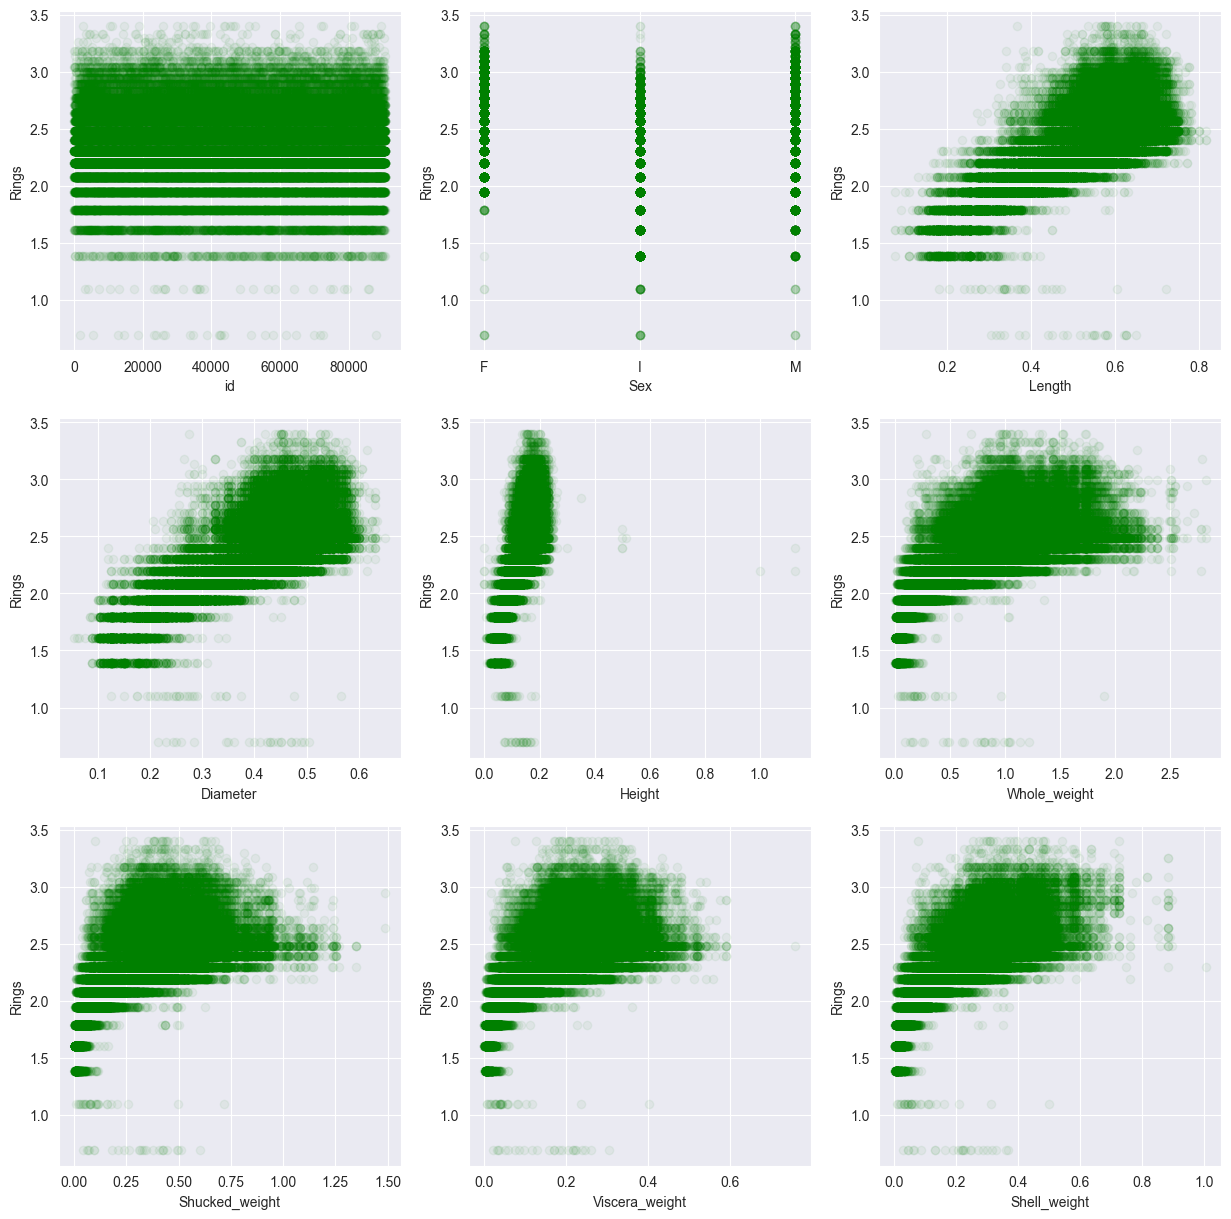

In [4]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for i, feature in enumerate(df.drop(columns=["Rings"]).columns):
    ax[i//3, i%3].scatter(df[feature], df["Rings"], alpha=0.05, color="green")
    ax[i//3, i%3].set(xlabel=feature, ylabel="Rings")

Видим, что от столбца id зависимости нет, поэтому в дальнейшем не будем его использовать.

<Axes: >

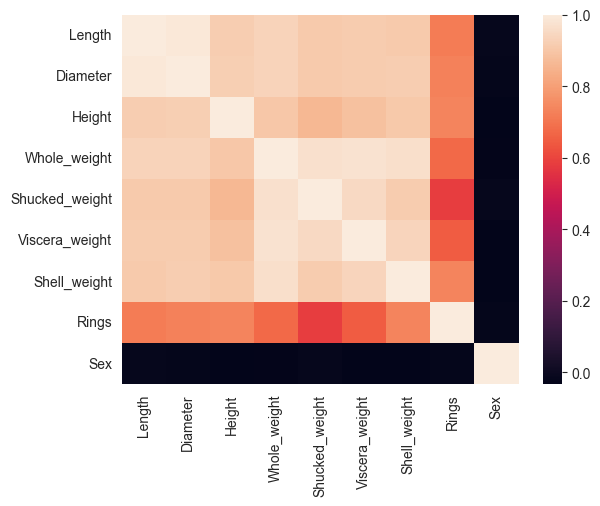

In [5]:
df_order_enc = df.drop(columns=["id", "Sex"])
df_order_enc["Sex"] = np.where(df["Sex"] == "M", 1, np.where(df["Sex"] == "I", 0, -1))

sns.heatmap(df_order_enc.corr())

## Бейслайн

### 1. Проверка на выбросы

In [6]:
pd.DataFrame(df.isna().sum())

0
id              0
Sex             0
Length          0
Diameter        0
Height          0
Whole_weight    0
Shucked_weight  0
Viscera_weight  0
Shell_weight    0
Rings           0

In [7]:
pd.DataFrame(X_val.isna().sum())

0
id              0
Sex             0
Length          0
Diameter        0
Height          0
Whole_weight    0
Shucked_weight  0
Viscera_weight  0
Shell_weight    0

Видим, что пропусков нет, заполнять ничего не нужно

### 2. Проверка на выбросы

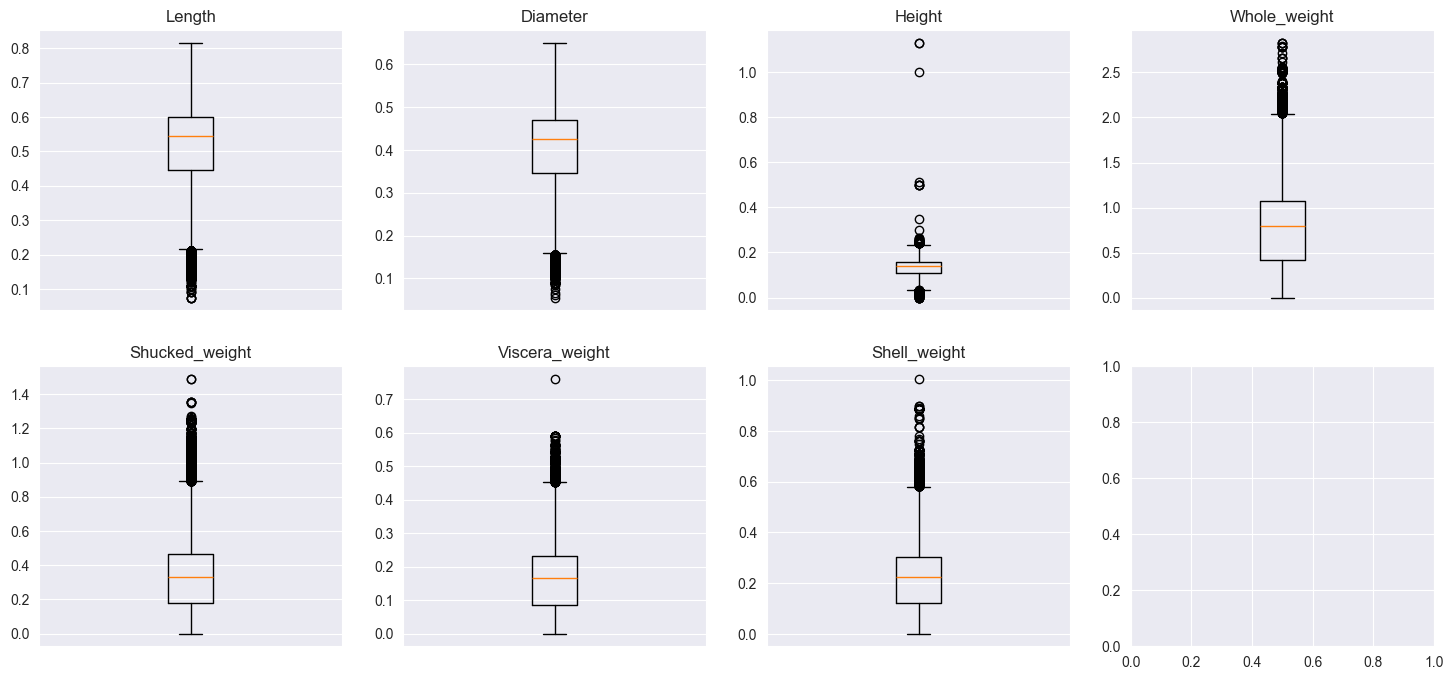

In [8]:
def check_outliers(_df: pd.DataFrame, whis: int = 3) -> None:
    _, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))

    for i, feature in enumerate(non_cat_features):
        if feature != "Sex":
            axs[i//4, i%4].boxplot(x=_df[feature], whis=whis)
            axs[i//4, i%4].set(title=feature)
            axs[i//4, i%4].get_xaxis().set_visible(False)

    plt.show()

whis = 1.5
check_outliers(df, whis)

В датасете осталось 87266 строк


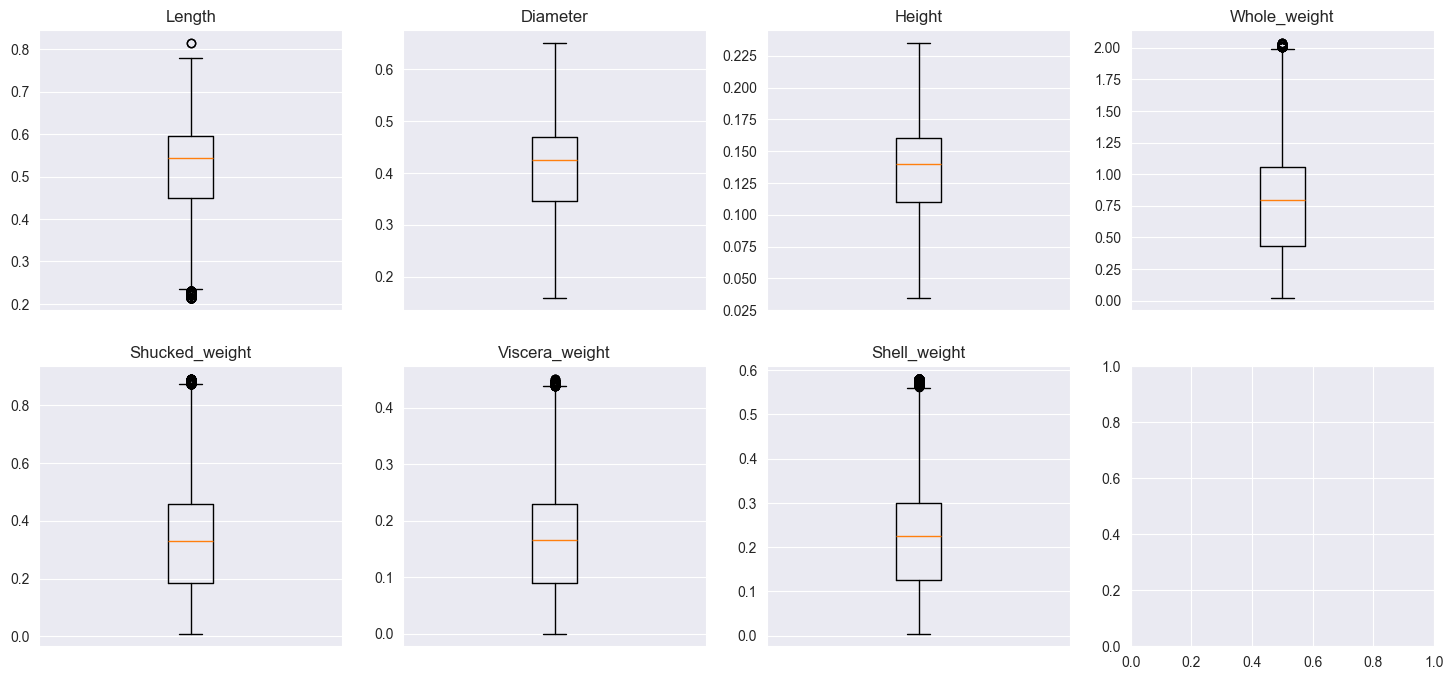

In [9]:
Q1, Q3 = df[non_cat_features].quantile(0.25), df[non_cat_features].quantile(0.75)
IQR = Q3 - Q1
top_lim, bottom_lim = Q3 + whis * IQR, Q1 - whis * IQR

mask = (df[non_cat_features] >= bottom_lim) & (df[non_cat_features] <= top_lim)
df = df[mask.all(axis=1)]

print(f"В датасете осталось {len(df)} строк")
check_outliers(df, whis)

### 3. Кодирование

In [10]:
non_cat_features = ["Length", "Diameter", "Height", "Whole_weight", "Shucked_weight", "Viscera_weight", "Shell_weight"]
cat_features = ["Sex"]

In [11]:
X_train, y_train = df[non_cat_features + cat_features], df["Rings"]
X_train_CV, X_test_CV, y_train_CV, y_test_CV = train_test_split(X_train, y_train, test_size=0.23)

In [13]:
train_pool = Pool(X_train_CV, label=y_train_CV, cat_features=cat_features)
test_pool = Pool(X_test_CV, label=y_test_CV, cat_features=cat_features)

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
).fit(train_pool)
y_predict = catboost_model.predict(data=X_test_CV)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(y_predict)):.5f}")

Learning rate set to 0.079597
0:	learn: 0.2581074	total: 18.4ms	remaining: 18.4s
1:	learn: 0.2472748	total: 42.1ms	remaining: 21s
2:	learn: 0.2380066	total: 53.2ms	remaining: 17.7s
3:	learn: 0.2295387	total: 63.4ms	remaining: 15.8s
4:	learn: 0.2224335	total: 74.1ms	remaining: 14.8s
5:	learn: 0.2155760	total: 92.8ms	remaining: 15.4s
6:	learn: 0.2092870	total: 101ms	remaining: 14.4s
7:	learn: 0.2037517	total: 111ms	remaining: 13.7s
8:	learn: 0.1989396	total: 120ms	remaining: 13.2s
9:	learn: 0.1944823	total: 139ms	remaining: 13.8s
10:	learn: 0.1908010	total: 152ms	remaining: 13.7s
11:	learn: 0.1873937	total: 164ms	remaining: 13.5s
12:	learn: 0.1844606	total: 176ms	remaining: 13.4s
13:	learn: 0.1817905	total: 210ms	remaining: 14.8s
14:	learn: 0.1792498	total: 223ms	remaining: 14.6s
15:	learn: 0.1768504	total: 245ms	remaining: 15.1s
16:	learn: 0.1746345	total: 257ms	remaining: 14.9s
17:	learn: 0.1727117	total: 266ms	remaining: 14.5s
18:	learn: 0.1709857	total: 275ms	remaining: 14.2s
19:	lea

In [14]:
metrics = catboost_model.eval_metrics(test_pool,
                            metrics=["RMSE"],
                            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Генерация и отбор признаков.

In [15]:
ofe = OpenFE()
features = ofe.fit(data=X_train, label=y_train, n_jobs=4, seed=RANDOM_SEED, categorical_features=cat_features)
X_train_FE, X_valid_FE = transform(X_train, X_val, features, n_jobs=4)
X_train_FE

The number of candidate features is 266
Start stage I selection.


  0%|          | 0/16 [00:00<?, ?it/s]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train

  6%|▋         | 1/16 [00:04<01:08,  4.57s/it]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 19%|█▉        | 3/16 [00:04<00:15,  1.23s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to rem

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to re

 31%|███▏      | 5/16 [00:05<00:09,  1.18it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to rem

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 44%|████▍     | 7/16 [00:05<00:04,  1.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to rem

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 50%|█████     | 8/16 [00:06<00:03,  2.15it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 56%|█████▋    | 9/16 [00:06<00:03,  1.84it/s]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 69%|██████▉   | 11/16 [00:07<00:01,  2.90it/s]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the trai

/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 75%|███████▌  | 12/16 [00:07<00:01,  3.33it/s]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

 81%|████████▏ | 13/16 [00:07<00:00,  3.09it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 0
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more

 88%|████████▊ | 14/16 [00:07<00:00,  3.03it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

 94%|█████████▍| 15/16 [00:08<00:00,  3.57it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

100%|██████████| 16/16 [00:08<00:00,  1.90it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4
[LightGBM] [Info] Number of data points in the train set: 8726, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

88 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


  0%|          | 0/15 [00:00<?, ?it/s]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to

  7%|▋         | 1/15 [00:06<01:37,  6.93s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 243
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to

 13%|█▎        | 2/15 [00:07<00:44,  3.42s/it]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_col_wise=true` to 

 27%|██▋       | 4/15 [00:08<00:16,  1.47s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 253
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to

 33%|███▎      | 5/15 [00:11<00:20,  2.00s/it]/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` t

 47%|████▋     | 7/15 [00:13<00:11,  1.45s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 226
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` t

 60%|██████    | 9/15 [00:16<00:09,  1.53s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` t

 67%|██████▋   | 10/15 [00:17<00:06,  1.40s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
 73%|███████▎  | 11/15 [00:17<00:04,  1.13s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


/Users/21903294/miniconda3/envs/kaggle/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` t

 80%|████████  | 12/15 [00:19<00:04,  1.35s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to

 87%|████████▋ | 13/15 [00:21<00:02,  1.36s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 252
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


100%|██████████| 15/15 [00:21<00:00,  1.46s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 1


The number of remaining candidate features is 177
Start stage II selection.


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Finish data processing.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35945
[LightGBM] [Info] Number of data points in the train set: 69812, number of used features: 185


Length  Diameter  Height  Whole_weight  Shucked_weight  \
openfe_index                                                           
0              0.550     0.430   0.150        0.7715          0.3285   
1              0.630     0.490   0.145        1.1300          0.4580   
3              0.595     0.475   0.150        0.9145          0.3755   
4              0.555     0.425   0.130        0.7820          0.3695   
5              0.610     0.480   0.170        1.2010          0.5335   
...              ...       ...     ...           ...             ...   
90610          0.335     0.235   0.075        0.1585          0.0685   
90611          0.555     0.425   0.150        0.8790          0.3865   
90612          0.435     0.330   0.095        0.3215          0.1510   
90613          0.345     0.270   0.075        0.2000          0.0980   
90614          0.425     0.325   0.100        0.3455          0.1525   

              Viscera_weight  Shell_weight Sex  autoFE_f_0  autoFE_f_1  ...  \
openfe_index                                                            ...   
0                     0.1465        0.2400   F    2.291667    0.036000  ...   
1                     0.2765        0.3200   F    1.968750    0.046400  ...   
3                     0.2055        0.2500   M    2.380000    0.037500  ...   
4                     0.1600        0.1975   I    2.810127    0.025675  ...   
5                     0.3135        0.3085   F    1.977310    0.052445  ...   
...                      ...           ...  ..         ...         ...  ...   
90610                 0.0370        0.0450   M    7.444444    0.003375  ...   
90611                 0.1815        0.2400   M    2.312500    0.036000  ...   
90612                 0.0785        0.0815   I    5.337423    0.007743  ...   
90613                 0.0490        0.0700   I    4.928571    0.005250  ...   
90614                 0.0785        0.1050   I    4.047619    0.010500  ...   

              autoFE_f_167  autoFE_f_168  autoFE_f_169  autoFE_f_170  \
openfe_index                                                           
0                   0.2650           3.0      0.107912        0.4205   
1                   0.2500           3.0      0.209764        0.3600   
3                   0.2650           3.0      0.141000        0.4205   
4                   0.1955           3.0      0.136530        0.3950   
5                   0.3300           3.0      0.284622        0.5260   
...                    ...           ...           ...           ...   
90610               0.0435           3.0      0.004692        0.1065   
90611               0.2650           3.0      0.149382        0.4205   
90612               0.0800           3.0      0.022801        0.3370   
90613               0.0435           3.0      0.009604        0.1065   
90614               0.0950           3.0      0.023256        0.3395   

              autoFE_f_171  autoFE_f_172  autoFE_f_173  autoFE_f_174  \
openfe_index                                                           
0                   0.1465        0.2050      0.057600         0.455   
1                   0.2765        0.1835      0.102400         0.445   
3                   0.2055        0.2050      0.062500         0.455   
4                   0.1600        0.1475      0.039006         0.405   
5                   0.3135        0.2475      0.095172         0.475   
...                    ...           ...           ...           ...   
90610               0.0370        0.0315      0.002025         0.230   
90611               0.1815        0.2050      0.057600         0.455   
90612               0.0785        0.0575      0.006642         0.290   
90613               0.0490        0.0315      0.004900         0.230   
90614               0.0785        0.0680      0.011025         0.315   

              autoFE_f_175  autoFE_f_176  
openfe_index                              
0                   0.3285      0.577813  
1                   0.4580      0.562337  
3  

In [16]:
cols = X_train_FE.columns
num_cols = X_train_FE._get_numeric_data().columns

feature_cols = list(set(cols) - set(num_cols))
feature_cols.remove("Sex")

X_train_FE = X_train_FE.drop(columns=feature_cols, axis=1)
X_valid_FE = X_valid_FE.drop(columns=feature_cols, axis=1)

X_train_FE[num_cols] = X_train_FE[num_cols].astype(float)
X_valid_FE[num_cols] = X_valid_FE[num_cols].astype(float)

In [17]:
X_train_CVFE, X_test_CVFE, y_train_CV, y_test_CV = train_test_split(X_train_FE, y_train, test_size=0.23)

In [18]:
catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    cat_features=cat_features,
).fit(X_train_CVFE, y_train_CV)
y_predict = catboost_model.predict(data=X_test_CVFE)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(y_predict)):.5f}")

Learning rate set to 0.079597
0:	learn: 0.2567673	total: 37.6ms	remaining: 37.5s
1:	learn: 0.2449603	total: 68.2ms	remaining: 34s
2:	learn: 0.2342782	total: 91.8ms	remaining: 30.5s
3:	learn: 0.2248500	total: 116ms	remaining: 28.9s
4:	learn: 0.2162083	total: 139ms	remaining: 27.7s
5:	learn: 0.2085118	total: 165ms	remaining: 27.3s
6:	learn: 0.2017012	total: 188ms	remaining: 26.6s
7:	learn: 0.1957424	total: 213ms	remaining: 26.4s
8:	learn: 0.1903501	total: 237ms	remaining: 26.1s
9:	learn: 0.1857086	total: 271ms	remaining: 26.8s
10:	learn: 0.1816177	total: 312ms	remaining: 28s
11:	learn: 0.1780210	total: 360ms	remaining: 29.6s
12:	learn: 0.1747258	total: 392ms	remaining: 29.8s
13:	learn: 0.1719491	total: 418ms	remaining: 29.5s
14:	learn: 0.1693633	total: 444ms	remaining: 29.1s
15:	learn: 0.1670347	total: 477ms	remaining: 29.3s
16:	learn: 0.1650038	total: 523ms	remaining: 30.2s
17:	learn: 0.1632120	total: 565ms	remaining: 30.8s
18:	learn: 0.1616113	total: 599ms	remaining: 30.9s
19:	learn: 0

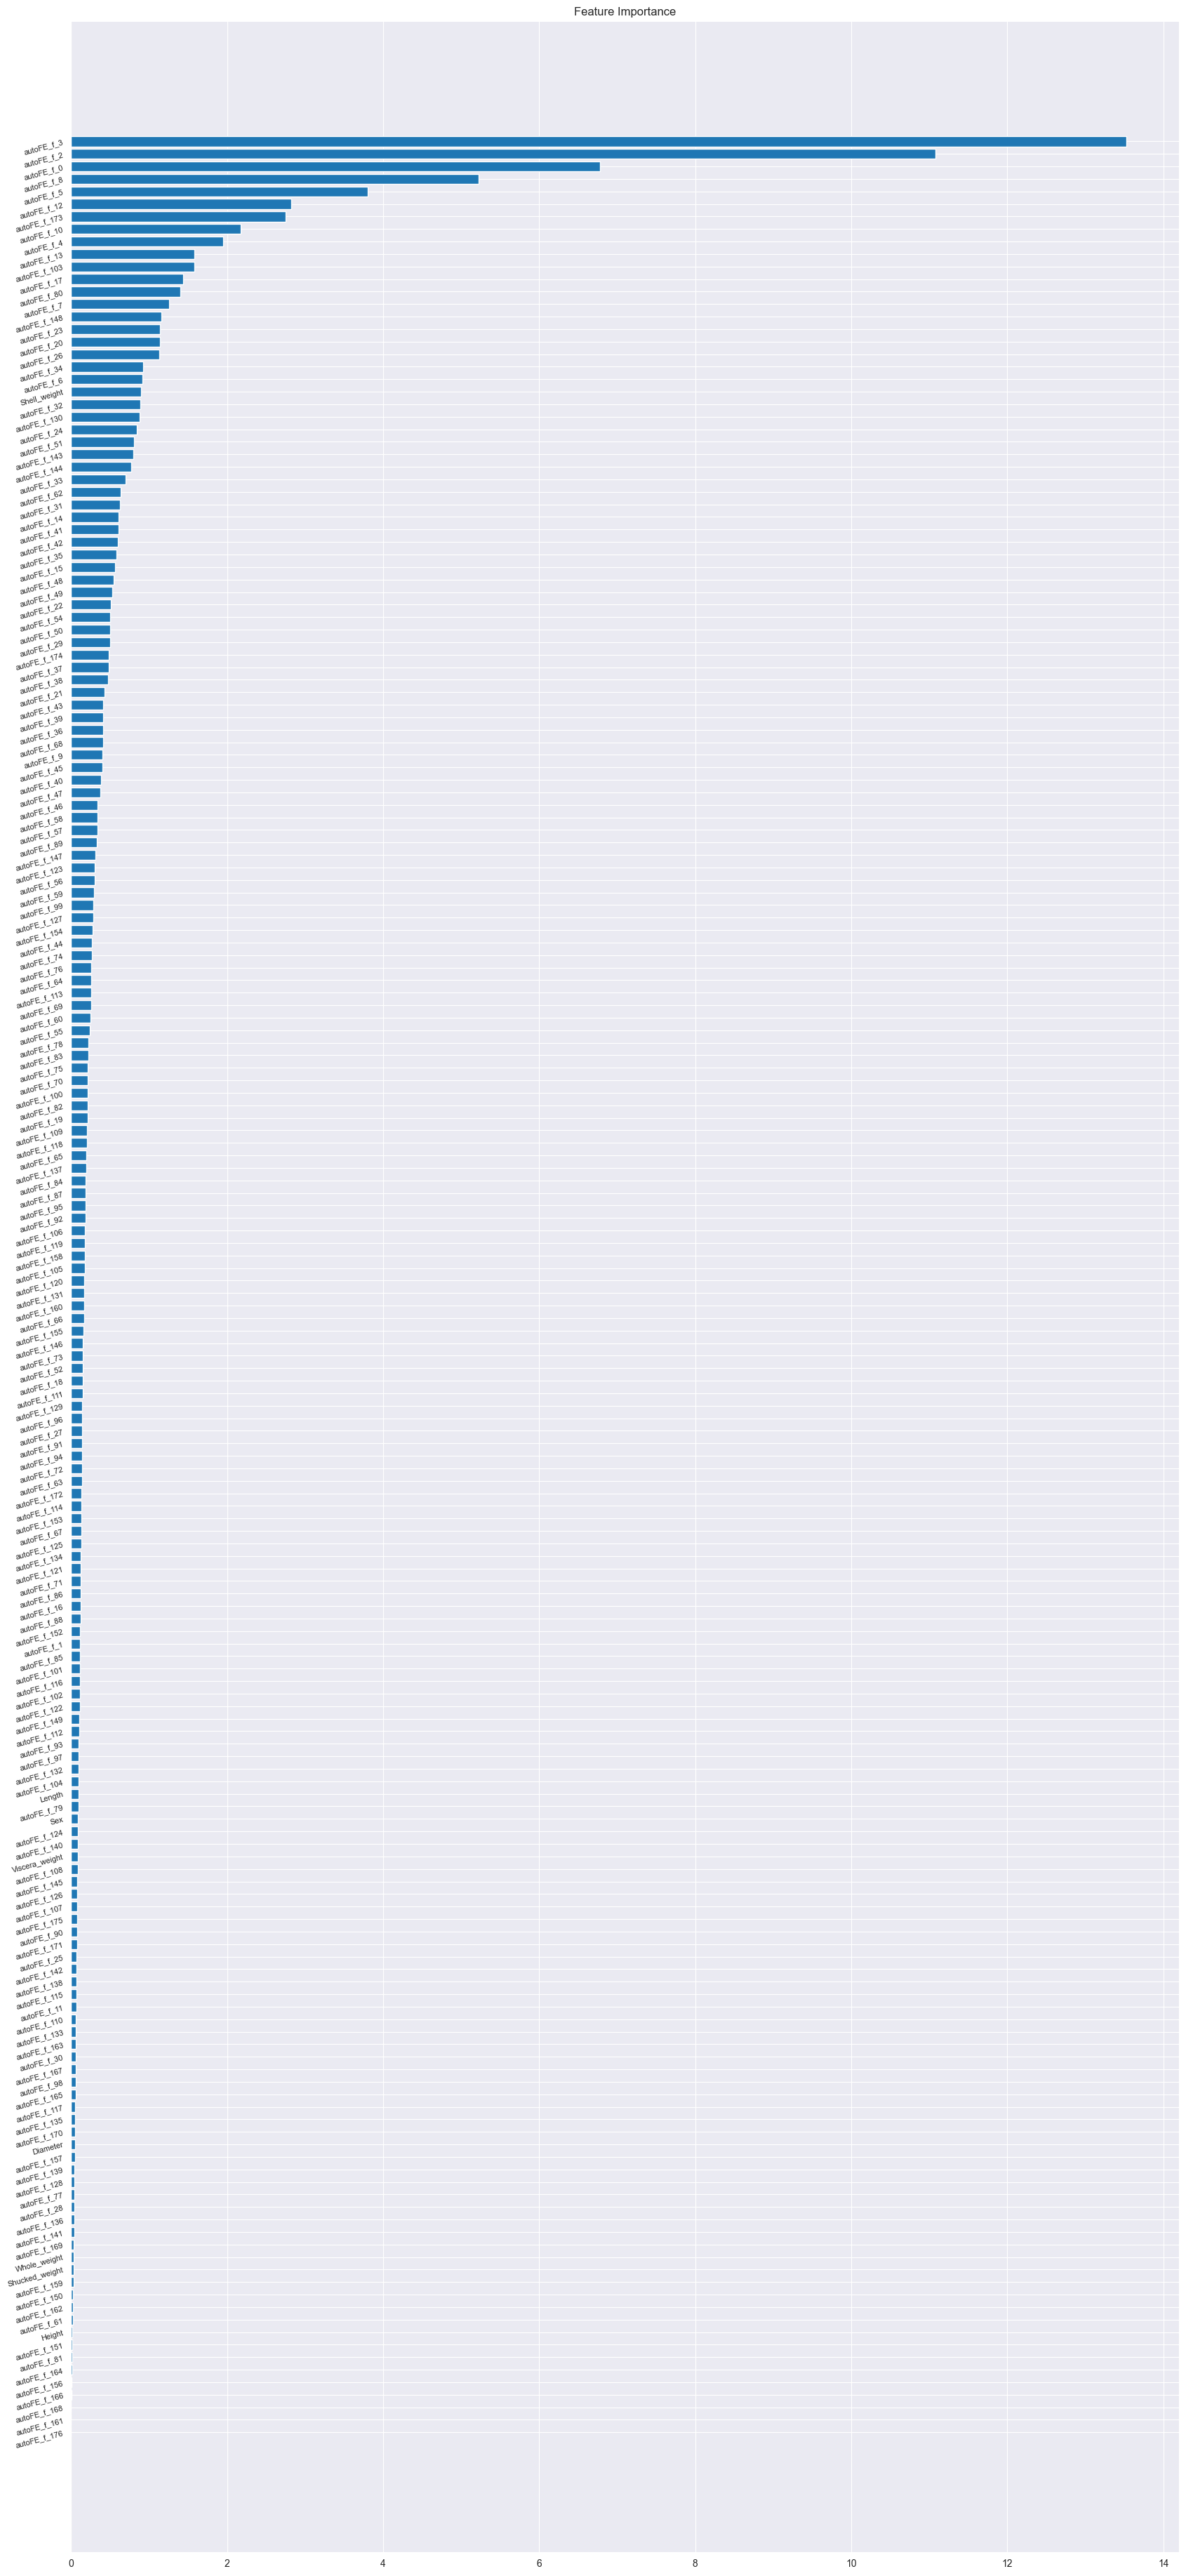

In [19]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(17, len(sorted_idx) * 0.2))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test_CVFE.columns)[sorted_idx], fontsize=8, rotation=15)
plt.title("Feature Importance")
plt.tight_layout()

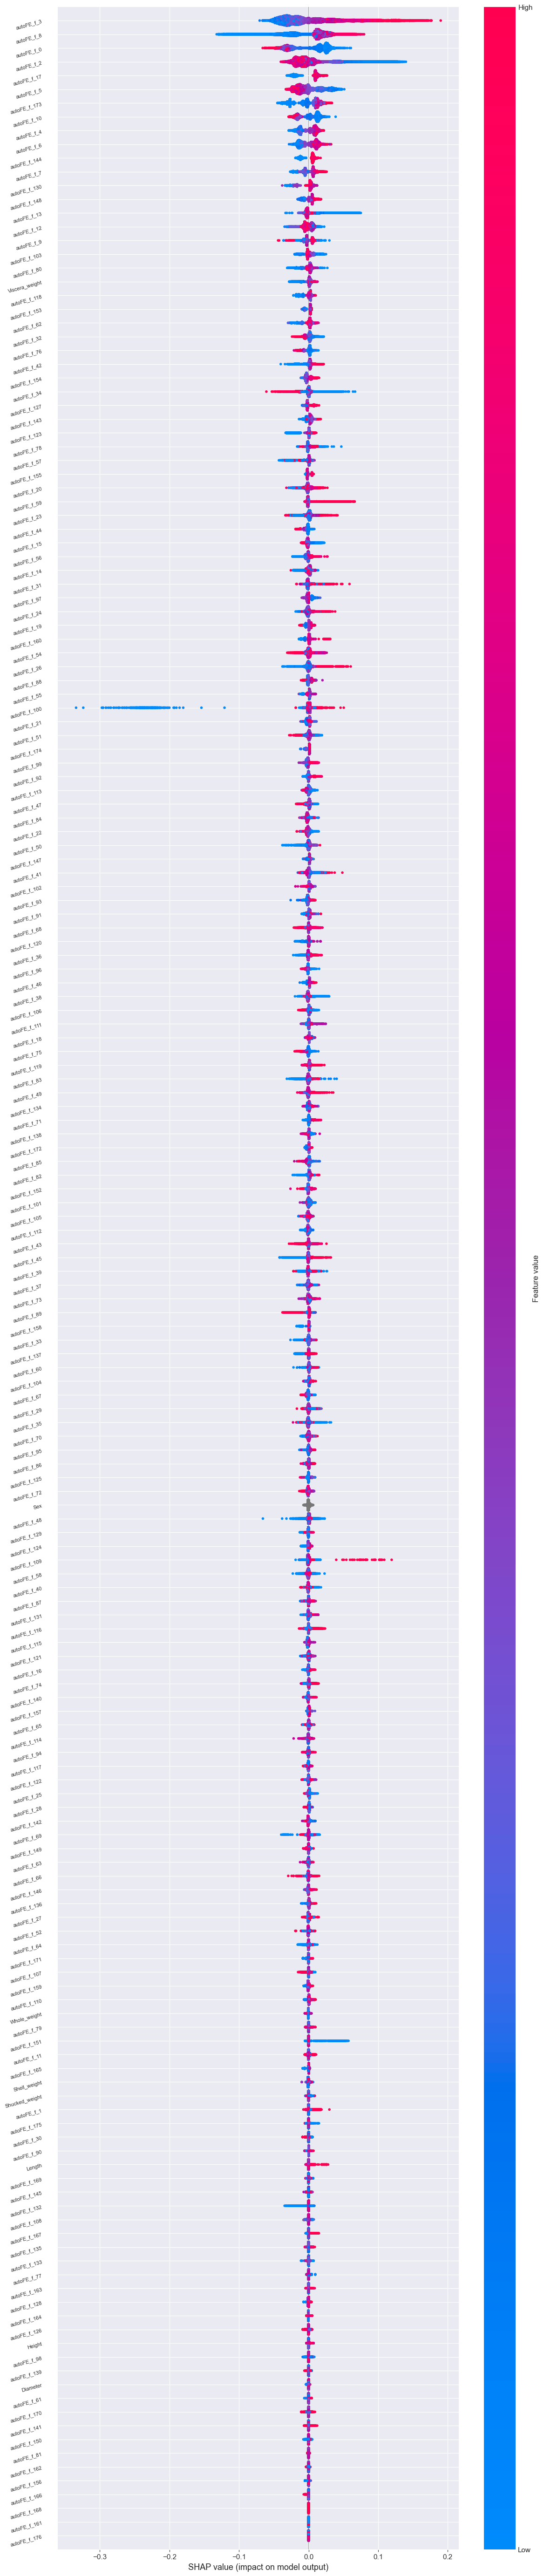

In [20]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(Pool(X_valid_FE.drop(columns=["id"]), cat_features=cat_features))
shap.summary_plot(shap_test, X_valid_FE.drop(columns=["id"]), max_display=X_valid_FE.shape[1], show=False)

plt.gcf().set_size_inches(15, len(sorted_idx) * 0.3)
plt.yticks(fontsize=8, rotation=15)
plt.show()

In [21]:
shap_sum = np.abs(shap_test).mean(axis=0)
importance_df = pd.DataFrame([X_train_FE.columns.to_list(), list(shap_sum)]).T
importance_df.columns = ["col_name", "shap_importance"]
importance_df = importance_df.sort_values("shap_importance", ascending=False)
importance_df

col_name shap_importance
11     autoFE_f_3        0.033578
16     autoFE_f_8        0.024833
8      autoFE_f_0        0.024801
10     autoFE_f_2        0.017883
25    autoFE_f_17        0.014771
..            ...             ...
163  autoFE_f_156        0.000088
173  autoFE_f_166        0.000008
168  autoFE_f_161             0.0
175  autoFE_f_168             0.0
183  autoFE_f_176             0.0

[184 rows x 2 columns]

In [22]:
# cutoff_ind = importance_df.index[importance_df["col_name"] == "autoFE_f_57"].to_list()[0]
cutoff_ind = 40
importance_df = importance_df[:cutoff_ind]
cutoff_ind

40

In [23]:
X_train_CVFE_proc = X_train_CVFE[importance_df["col_name"]]
X_test_CVFE_proc = X_test_CVFE[importance_df["col_name"]]
X_valid_FE_proc = X_valid_FE[importance_df["col_name"].to_list() + ["id"]]

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    # cat_features=["Sex"]
).fit(X_train_CVFE_proc, y_train_CV)
y_predict = catboost_model.predict(data=X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(y_predict)):.5f}")

Learning rate set to 0.079597
0:	learn: 0.2569297	total: 114ms	remaining: 1m 53s
1:	learn: 0.2450190	total: 200ms	remaining: 1m 39s
2:	learn: 0.2344861	total: 234ms	remaining: 1m 17s
3:	learn: 0.2248834	total: 268ms	remaining: 1m 6s
4:	learn: 0.2163714	total: 312ms	remaining: 1m 2s
5:	learn: 0.2088417	total: 342ms	remaining: 56.7s
6:	learn: 0.2019820	total: 379ms	remaining: 53.7s
7:	learn: 0.1959272	total: 412ms	remaining: 51.1s
8:	learn: 0.1906391	total: 437ms	remaining: 48.2s
9:	learn: 0.1859620	total: 464ms	remaining: 45.9s
10:	learn: 0.1817520	total: 494ms	remaining: 44.4s
11:	learn: 0.1781023	total: 513ms	remaining: 42.3s
12:	learn: 0.1747518	total: 538ms	remaining: 40.9s
13:	learn: 0.1718041	total: 563ms	remaining: 39.6s
14:	learn: 0.1692515	total: 589ms	remaining: 38.7s
15:	learn: 0.1668972	total: 615ms	remaining: 37.8s
16:	learn: 0.1649120	total: 651ms	remaining: 37.7s
17:	learn: 0.1630805	total: 753ms	remaining: 41.1s
18:	learn: 0.1615911	total: 795ms	remaining: 41.1s
19:	lear

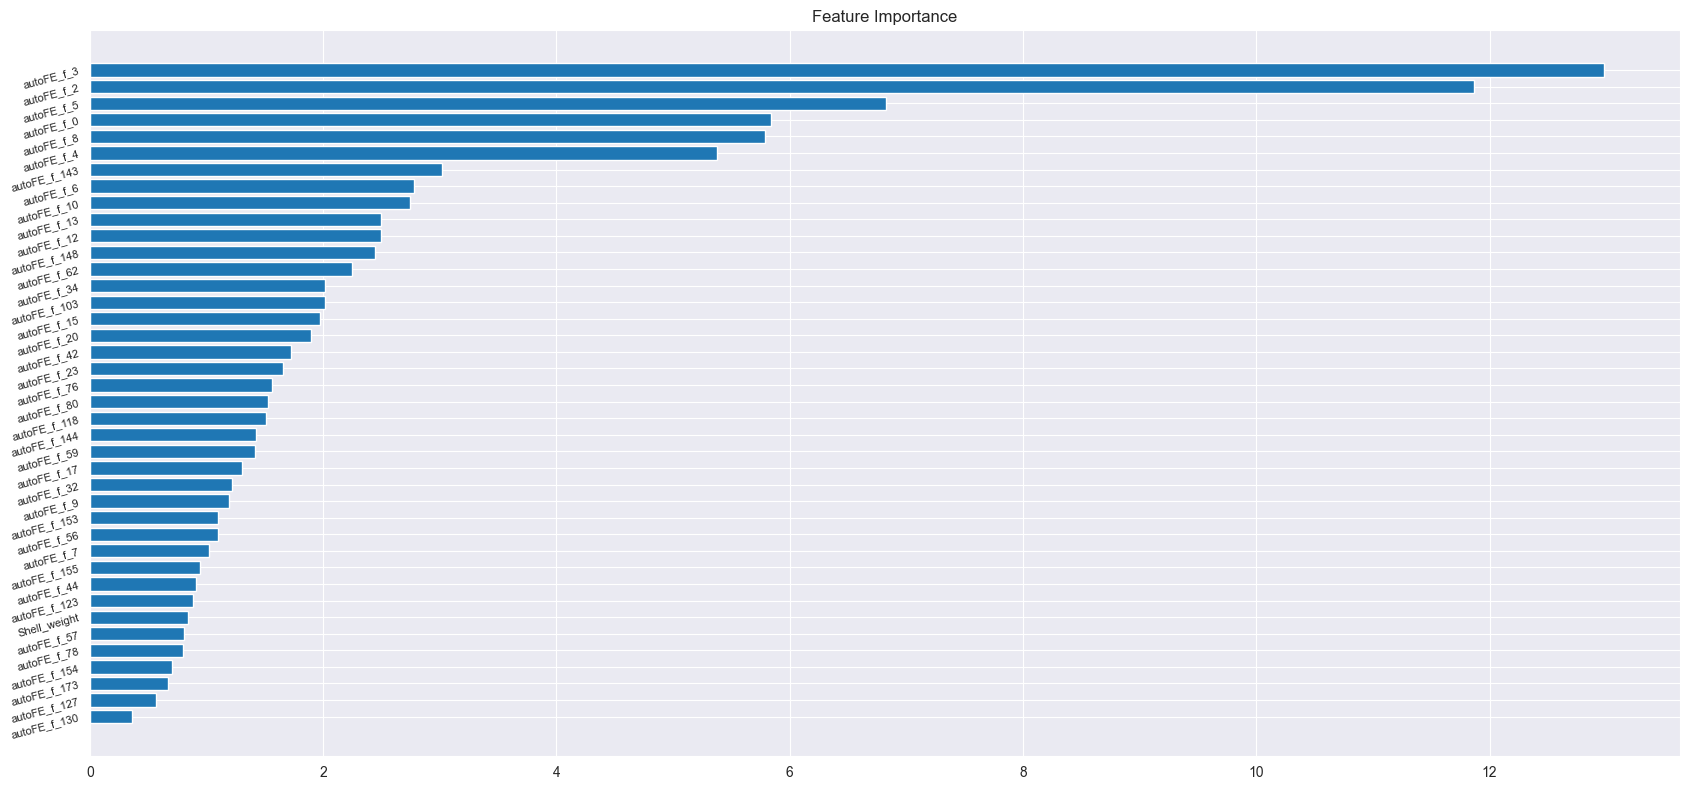

In [24]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(17, len(sorted_idx) * 0.2))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test_CVFE_proc.columns)[sorted_idx], fontsize=8, rotation=15)
plt.title("Feature Importance")
plt.tight_layout()

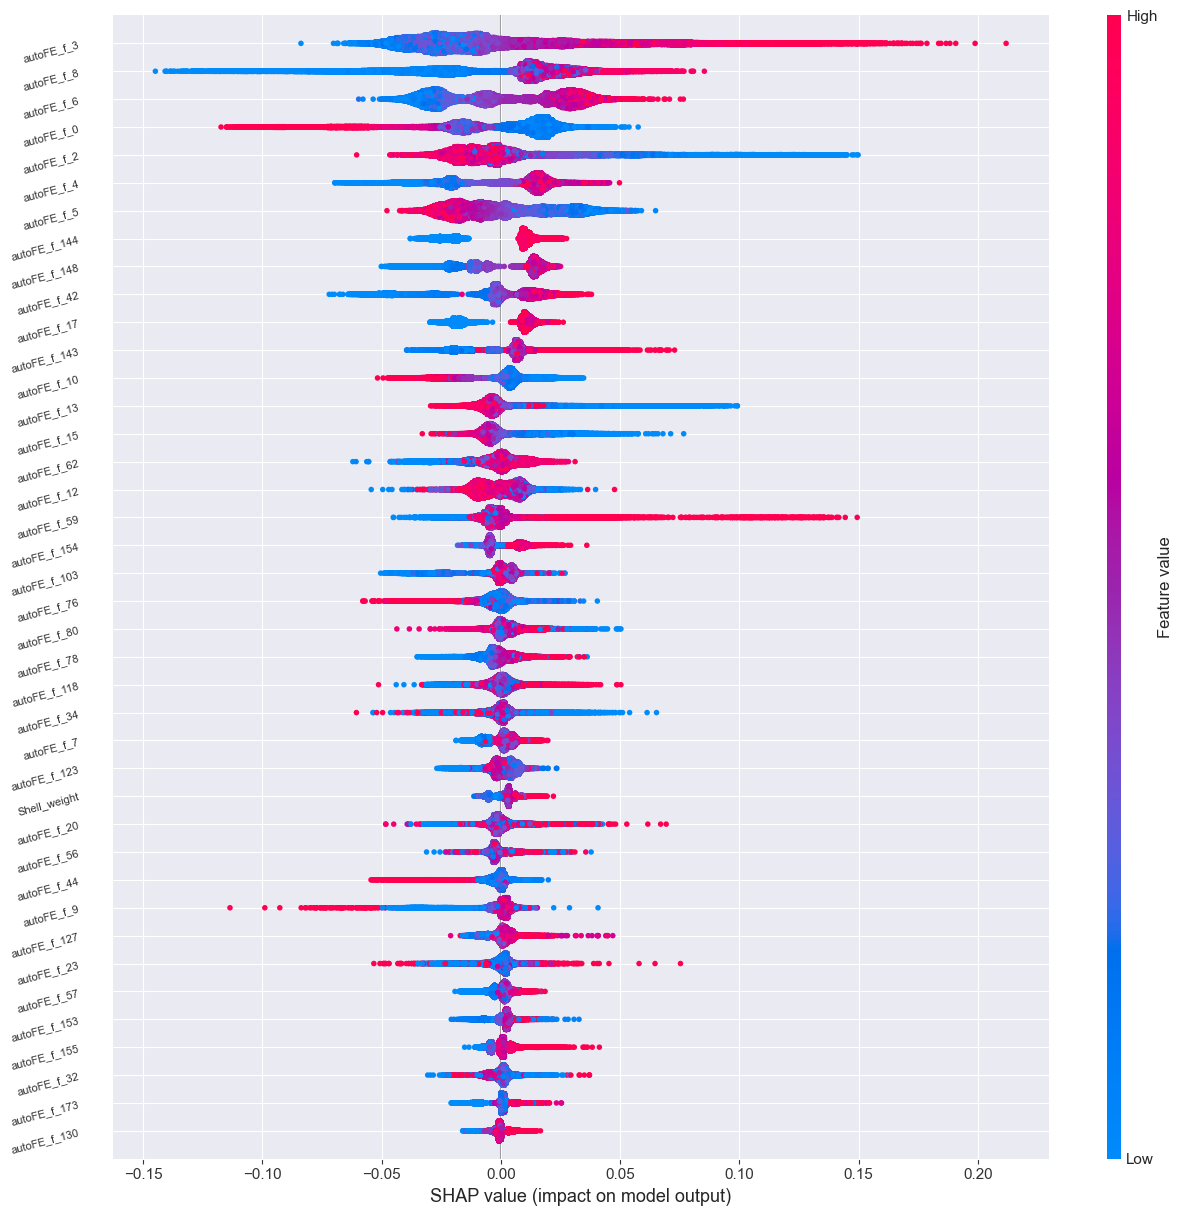

In [25]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(X_valid_FE_proc.drop(columns=["id"]))
shap.summary_plot(shap_test, X_valid_FE_proc.drop(columns=["id"]), max_display=X_valid_FE_proc.shape[1], show=False)

plt.gcf().set_size_inches(15, len(sorted_idx) * 0.3)
plt.yticks(fontsize=8, rotation=15)
plt.show()

In [26]:
features_to_delete = set(["autoFE_f_" + str(feature_num) for feature_num in [117, 158, 16, 38, 9, 109, 20, 130, 30, 80, 121, 74, 34,
                                                                             10, 100, 2, 0]] + [])
importance_df = importance_df[~importance_df["col_name"].isin(features_to_delete)]
print(len(importance_df))
importance_df

32


col_name shap_importance
11     autoFE_f_3        0.033578
16     autoFE_f_8        0.024833
25    autoFE_f_17        0.014771
13     autoFE_f_5        0.014541
180  autoFE_f_173        0.014074
12     autoFE_f_4        0.010523
14     autoFE_f_6        0.010463
151  autoFE_f_144        0.008476
15     autoFE_f_7         0.00836
155  autoFE_f_148        0.005813
21    autoFE_f_13        0.004794
20    autoFE_f_12        0.004672
110  autoFE_f_103        0.004347
6    Shell_weight        0.004008
125  autoFE_f_118        0.003906
160  autoFE_f_153        0.003823
69    autoFE_f_62        0.003806
40    autoFE_f_32        0.003414
83    autoFE_f_76        0.003412
50    autoFE_f_42        0.003402
161  autoFE_f_154        0.003335
134  autoFE_f_127        0.002986
150  autoFE_f_143        0.002955
130  autoFE_f_123        0.002937
85    autoFE_f_78        0.002926
64    autoFE_f_57        0.002843
162  autoFE_f_155        0.002829
66    autoFE_f_59        0.002678
31    autoFE_f_23        0.002658
52    autoFE_f_44        0.002556
23    autoFE_f_15        0.002469
63    autoFE_f_56        0.002351

In [27]:
X_train_CVFE_proc = X_train_CVFE[importance_df["col_name"]]
X_test_CVFE_proc = X_test_CVFE[importance_df["col_name"]]
X_valid_FE_proc = X_valid_FE[importance_df["col_name"].to_list() + ["id"]]

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
    # cat_features=["Sex"]
).fit(X_train_CVFE_proc, y_train_CV)
y_predict = catboost_model.predict(data=X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(y_predict)):.5f}")

Learning rate set to 0.079597
0:	learn: 0.2571034	total: 97.8ms	remaining: 1m 37s
1:	learn: 0.2452546	total: 138ms	remaining: 1m 8s
2:	learn: 0.2346986	total: 219ms	remaining: 1m 12s
3:	learn: 0.2252316	total: 251ms	remaining: 1m 2s
4:	learn: 0.2167347	total: 286ms	remaining: 56.9s
5:	learn: 0.2089815	total: 318ms	remaining: 52.7s
6:	learn: 0.2021617	total: 350ms	remaining: 49.7s
7:	learn: 0.1959615	total: 373ms	remaining: 46.3s
8:	learn: 0.1905638	total: 400ms	remaining: 44s
9:	learn: 0.1857471	total: 424ms	remaining: 41.9s
10:	learn: 0.1816005	total: 451ms	remaining: 40.5s
11:	learn: 0.1778277	total: 471ms	remaining: 38.8s
12:	learn: 0.1745847	total: 563ms	remaining: 42.7s
13:	learn: 0.1716719	total: 590ms	remaining: 41.6s
14:	learn: 0.1690319	total: 617ms	remaining: 40.5s
15:	learn: 0.1666765	total: 649ms	remaining: 39.9s
16:	learn: 0.1646853	total: 684ms	remaining: 39.5s
17:	learn: 0.1630166	total: 703ms	remaining: 38.3s
18:	learn: 0.1614329	total: 732ms	remaining: 37.8s
19:	learn:

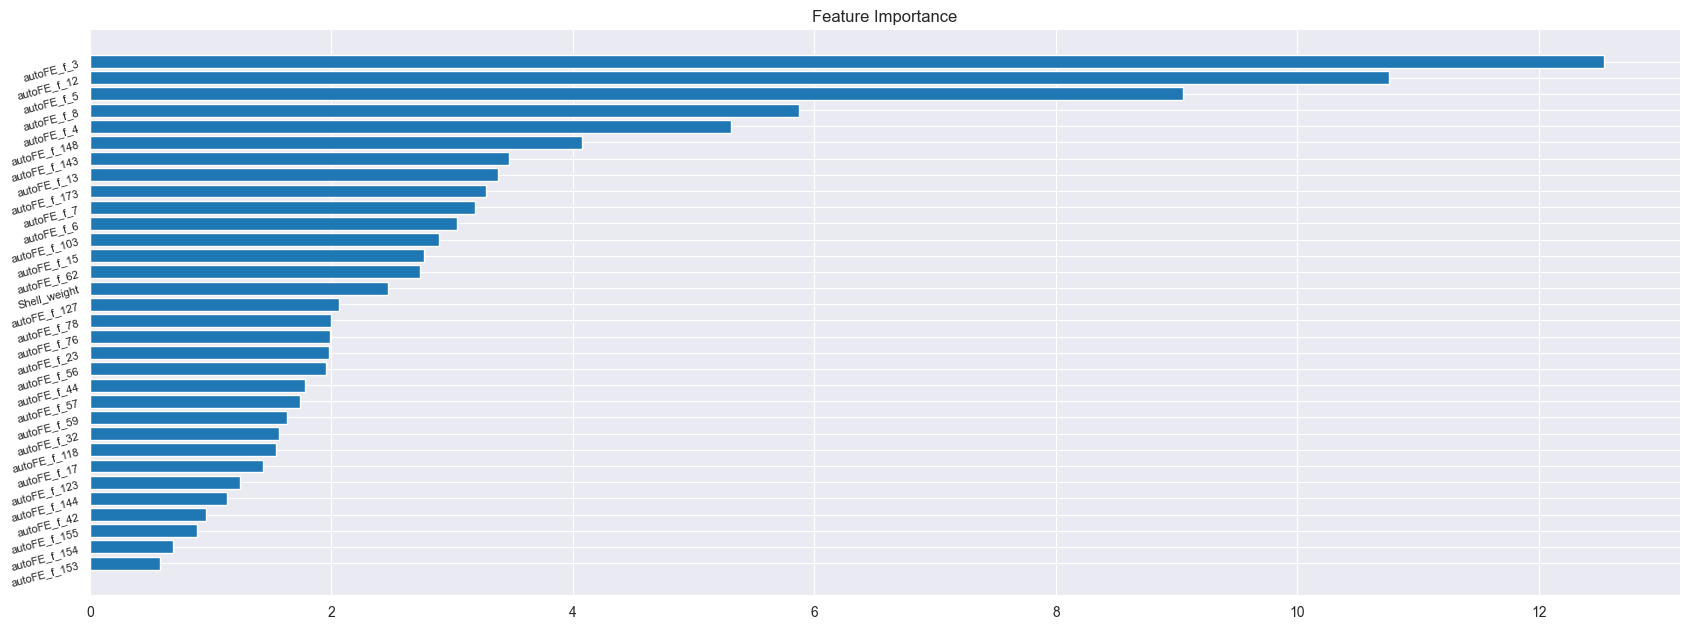

In [28]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(17, len(sorted_idx) * 0.2))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test_CVFE_proc.columns)[sorted_idx], fontsize=8, rotation=15)
plt.title("Feature Importance")
plt.tight_layout()

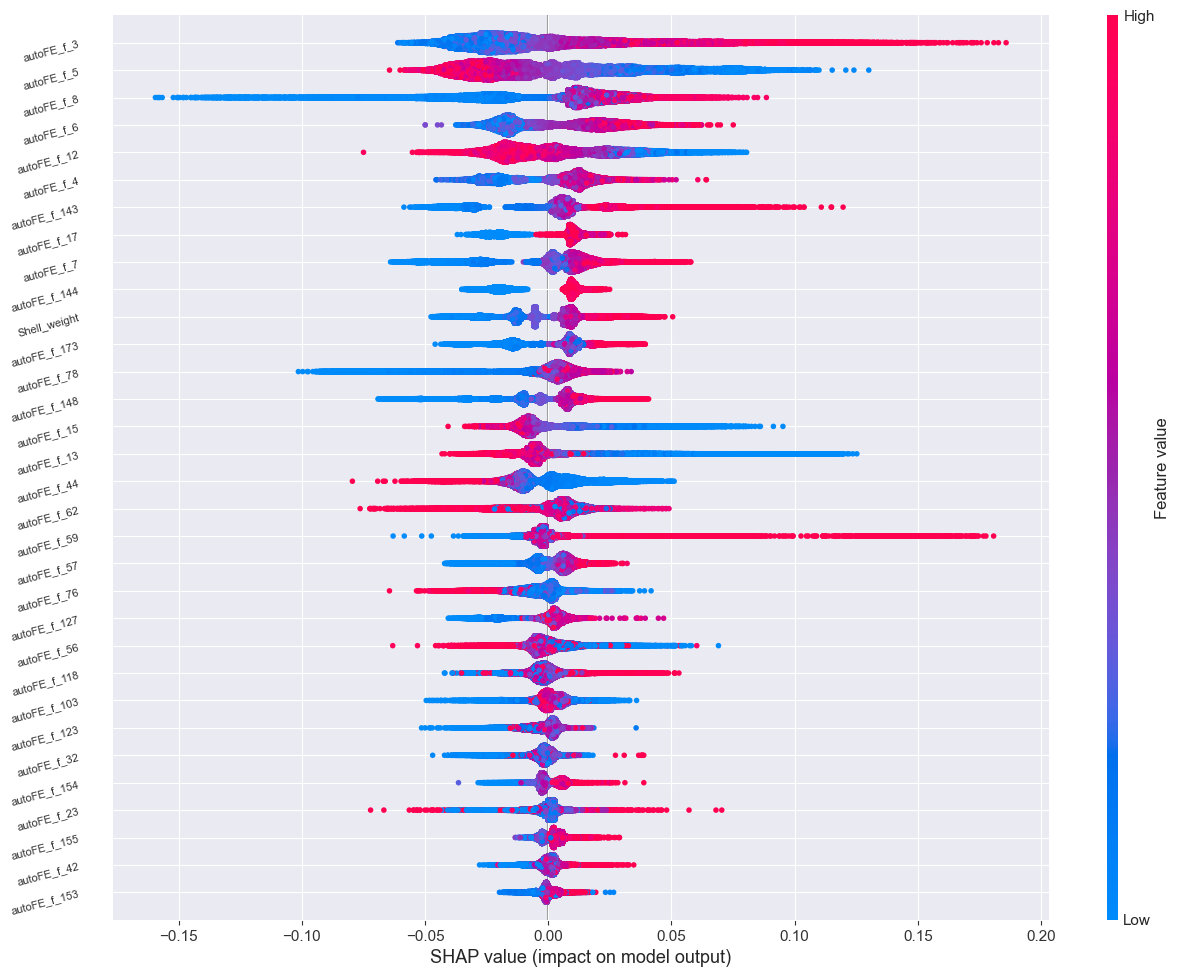

In [29]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(X_valid_FE_proc.drop(columns=["id"]))
shap.summary_plot(shap_test, X_valid_FE_proc.drop(columns=["id"]), max_display=X_test_CVFE_proc.shape[1], show=False)

plt.gcf().set_size_inches(15, len(sorted_idx) * 0.3)
plt.yticks(fontsize=8, rotation=15)
plt.show()

In [30]:
features_to_delete.update(set(["autoFE_f_" + str(feature_num) for feature_num in [126, 184, 29, 17, 141]] + []))
importance_df = importance_df[~importance_df["col_name"].isin(features_to_delete)]
print(len(importance_df))
importance_df

31


col_name shap_importance
11     autoFE_f_3        0.033578
16     autoFE_f_8        0.024833
13     autoFE_f_5        0.014541
180  autoFE_f_173        0.014074
12     autoFE_f_4        0.010523
14     autoFE_f_6        0.010463
151  autoFE_f_144        0.008476
15     autoFE_f_7         0.00836
155  autoFE_f_148        0.005813
21    autoFE_f_13        0.004794
20    autoFE_f_12        0.004672
110  autoFE_f_103        0.004347
6    Shell_weight        0.004008
125  autoFE_f_118        0.003906
160  autoFE_f_153        0.003823
69    autoFE_f_62        0.003806
40    autoFE_f_32        0.003414
83    autoFE_f_76        0.003412
50    autoFE_f_42        0.003402
161  autoFE_f_154        0.003335
134  autoFE_f_127        0.002986
150  autoFE_f_143        0.002955
130  autoFE_f_123        0.002937
85    autoFE_f_78        0.002926
64    autoFE_f_57        0.002843
162  autoFE_f_155        0.002829
66    autoFE_f_59        0.002678
31    autoFE_f_23        0.002658
52    autoFE_f_44        0.002556
23    autoFE_f_15        0.002469
63    autoFE_f_56        0.002351

In [31]:
X_train_CVFE_proc = X_train_CVFE[importance_df["col_name"]]
X_test_CVFE_proc = X_test_CVFE[importance_df["col_name"]]
X_valid_FE_proc = X_valid_FE[importance_df["col_name"].to_list() + ["id"]]

catboost_model = CatBoostRegressor(
    loss_function="RMSE",
).fit(X_train_CVFE_proc, y_train_CV)
y_predict = catboost_model.predict(data=X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(y_predict)):.5f}")

Learning rate set to 0.079597
0:	learn: 0.2569708	total: 27.8ms	remaining: 27.8s
1:	learn: 0.2450214	total: 54.1ms	remaining: 27s
2:	learn: 0.2344713	total: 82.9ms	remaining: 27.5s
3:	learn: 0.2251154	total: 115ms	remaining: 28.7s
4:	learn: 0.2167124	total: 134ms	remaining: 26.7s
5:	learn: 0.2090262	total: 150ms	remaining: 24.8s
6:	learn: 0.2022694	total: 173ms	remaining: 24.5s
7:	learn: 0.1961843	total: 192ms	remaining: 23.8s
8:	learn: 0.1907548	total: 220ms	remaining: 24.2s
9:	learn: 0.1859466	total: 265ms	remaining: 26.2s
10:	learn: 0.1817009	total: 321ms	remaining: 28.9s
11:	learn: 0.1779232	total: 396ms	remaining: 32.6s
12:	learn: 0.1745948	total: 472ms	remaining: 35.9s
13:	learn: 0.1717253	total: 561ms	remaining: 39.5s
14:	learn: 0.1691912	total: 599ms	remaining: 39.3s
15:	learn: 0.1668363	total: 617ms	remaining: 37.9s
16:	learn: 0.1648320	total: 651ms	remaining: 37.6s
17:	learn: 0.1630106	total: 686ms	remaining: 37.4s
18:	learn: 0.1614221	total: 729ms	remaining: 37.6s
19:	learn:

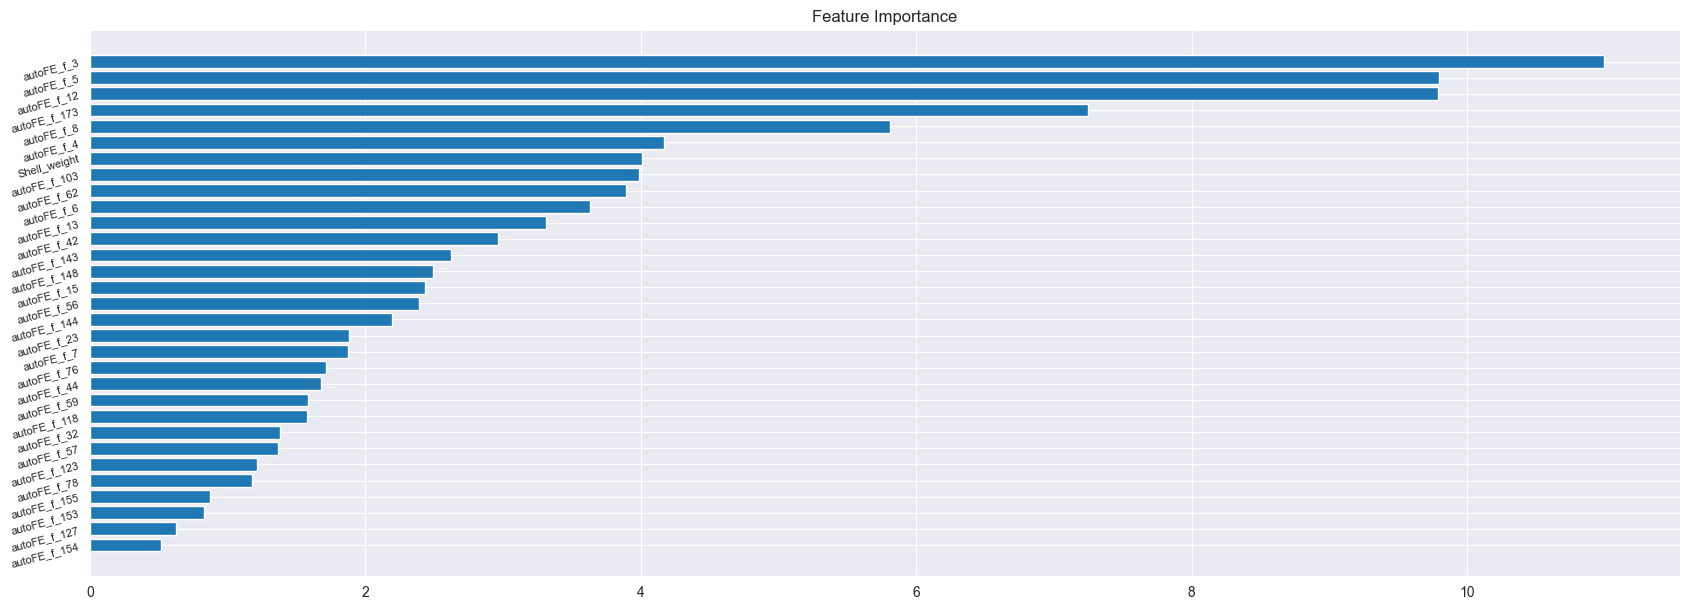

In [32]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(17, len(sorted_idx) * 0.2))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test_CVFE_proc.columns)[sorted_idx], fontsize=8, rotation=15)
plt.title("Feature Importance")
plt.tight_layout()

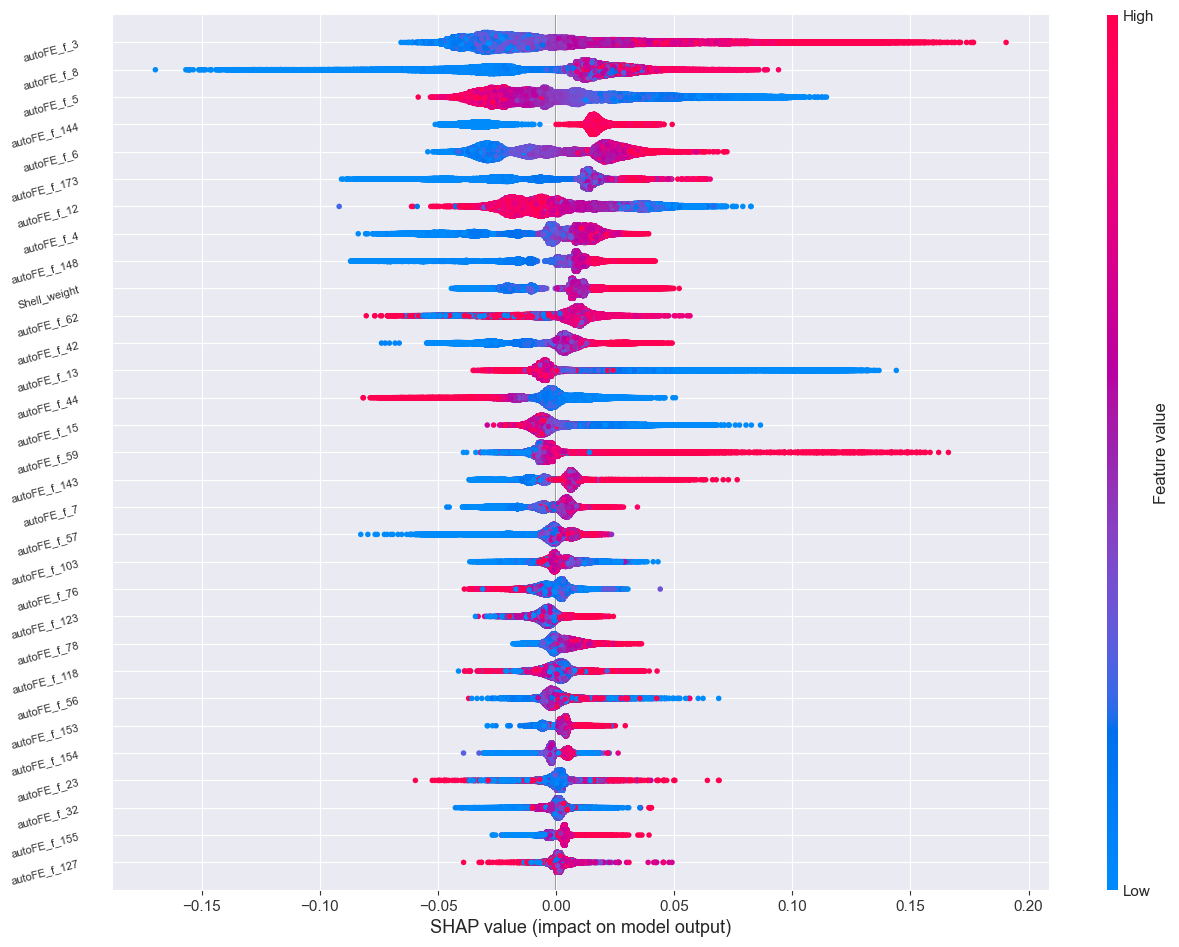

In [33]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(X_valid_FE_proc.drop(columns=["id"]))
shap.summary_plot(shap_test, X_valid_FE_proc.drop(columns=["id"]), max_display=X_test_CVFE_proc.shape[1], show=False)

plt.gcf().set_size_inches(15, len(sorted_idx) * 0.3)
plt.yticks(fontsize=8, rotation=15)
plt.show()

In [34]:
class ParamsOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test
    

    def objective(self, trial):
        catboost_params = {
            "verbose": False,
            "iterations": 1000,
            "loss_function":"RMSE",
            "random_state": RANDOM_SEED,
            "depth": trial.suggest_int("depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.01, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 80),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "l2_leaf_reg":  trial.suggest_float("l2_leaf_reg", 0, 1),
        }
        
        return self.fit(catboost_params)

    def fit(self, params):

        mskf = KFold(n_splits=10, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, y_valid = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            model = CatBoostRegressor(**params)
            model.fit(X_train, y_train)
        

            valid_preds = model.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds

        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))

        return oof_score

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize", sampler=TPESampler(multivariate=True, n_startup_trials=n_trials), pruner=optuna.pruners.MedianPruner())
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params


In [35]:
catboost_optimizer = ParamsOptimizer(X_train=X_train_CVFE_proc, X_test=X_test_CVFE_proc, y_train=y_train_CV, y_test=y_test_CV)
catboost_best_params = catboost_optimizer.optimize(n_trials=50)
catboost_best_params

[I 2024-12-08 14:14:26,599] A new study created in memory with name: no-name-63cc8821-ffd2-4161-9e89-076d4ec78821
[I 2024-12-08 14:18:30,692] Trial 3 finished with value: 0.15283440839811321 and parameters: {'depth': 3, 'subsample': 0.3301725235322661, 'min_data_in_leaf': 24, 'colsample_bylevel': 0.6500280342183483, 'learning_rate': 0.003632552358683223, 'l2_leaf_reg': 0.7346866891662669}. Best is trial 3 with value: 0.15283440839811321.
[I 2024-12-08 14:18:38,838] Trial 0 finished with value: 0.1563392732400551 and parameters: {'depth': 3, 'subsample': 0.3104954099995171, 'min_data_in_leaf': 69, 'colsample_bylevel': 0.8021800312564591, 'learning_rate': 0.0026428545605464648, 'l2_leaf_reg': 0.11338272604098754}. Best is trial 3 with value: 0.15283440839811321.
[I 2024-12-08 14:18:47,746] Trial 2 finished with value: 0.1502203443035548 and parameters: {'depth': 3, 'subsample': 0.5243692087343065, 'min_data_in_leaf': 28, 'colsample_bylevel': 0.5059951164146461, 'learning_rate': 0.0064958

Best trial:
  Value:  0.1502203443035548
  Params: 
    depth: 3
    subsample: 0.5243692087343065
    min_data_in_leaf: 28
    colsample_bylevel: 0.5059951164146461
    learning_rate: 0.006495830188298316
    l2_leaf_reg: 0.5755361213508882


{'depth': 3,
 'subsample': 0.5243692087343065,
 'min_data_in_leaf': 28,
 'colsample_bylevel': 0.5059951164146461,
 'learning_rate': 0.006495830188298316,
 'l2_leaf_reg': 0.5755361213508882}

In [36]:
catboost_model = CatBoostRegressor(**catboost_best_params).fit(X_train_CVFE_proc, y_train_CV)
catboost_model_predict = catboost_model.predict(data=X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(catboost_model_predict)):.5f}")

0:	learn: 0.2690773	total: 8ms	remaining: 7.99s
1:	learn: 0.2681139	total: 17.5ms	remaining: 8.75s
2:	learn: 0.2671344	total: 25.1ms	remaining: 8.34s
3:	learn: 0.2661474	total: 34.2ms	remaining: 8.52s
4:	learn: 0.2651875	total: 42.9ms	remaining: 8.54s
5:	learn: 0.2642339	total: 53.2ms	remaining: 8.81s
6:	learn: 0.2633117	total: 64ms	remaining: 9.08s
7:	learn: 0.2623907	total: 72.6ms	remaining: 9.01s
8:	learn: 0.2614743	total: 85.7ms	remaining: 9.43s
9:	learn: 0.2605692	total: 98.1ms	remaining: 9.71s
10:	learn: 0.2596578	total: 107ms	remaining: 9.6s
11:	learn: 0.2587530	total: 120ms	remaining: 9.87s
12:	learn: 0.2578740	total: 135ms	remaining: 10.2s
13:	learn: 0.2570351	total: 148ms	remaining: 10.4s
14:	learn: 0.2561908	total: 160ms	remaining: 10.5s
15:	learn: 0.2553216	total: 195ms	remaining: 12s
16:	learn: 0.2544675	total: 219ms	remaining: 12.6s
17:	learn: 0.2536161	total: 227ms	remaining: 12.4s
18:	learn: 0.2527986	total: 241ms	remaining: 12.4s
19:	learn: 0.2519631	total: 252ms	remai

In [37]:
class LightGBMOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test
    

    def objective(self, trial):

        lightboost_params = {
            "max_depth": trial.suggest_int("max_depth", 2, 13),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 50, 2500),
            "boosting_type": "gbdt",
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 0, 1),
            "lambda_l2": trial.suggest_float("lambda_l2", 0, 1),
            "min_split_gain": trial.suggest_float("min_split_gain", 0, 1),
            "max_bin": trial.suggest_int("max_bin", 10, 1000),
            "random_state": 42,
            "metric": "rmse",
            "top_rate": trial.suggest_float("top_rate", 0.1, 0.5),
            "other_rate": trial.suggest_float("other_rate", 0.1, 0.5),
            "max_delta_step": trial.suggest_float("max_delta_step", 0, 1),
            "verbosity": -1,
        }
        
        return self.fit(lightboost_params)

    def fit(self, params):

        mskf = KFold(n_splits=10, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, y_valid = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            lightgbm_model = LGBMRegressor(**params)
            lightgbm_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[early_stopping(100)])

            valid_preds = lightgbm_model.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds

        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))

        return oof_score

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize", sampler=TPESampler(multivariate=True, n_startup_trials=n_trials), pruner=optuna.pruners.MedianPruner())
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params

In [38]:
lightgbm_optimizer = LightGBMOptimizer(X_train=X_train_CVFE_proc, X_test=X_train_CVFE_proc, y_train=y_train_CV, y_test=y_test_CV)
lightgbm_best_params = lightgbm_optimizer.optimize(n_trials=50)

lightgbm_best_params

[I 2024-12-08 14:19:31,081] A new study created in memory with name: no-name-526a039f-b913-477e-a329-24af93e0221e


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 0.152153
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[67]	valid_0's rmse: 0.150965
Early stopping, best iteration is:
[63]	valid_0's rmse: 0.144496
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	valid_0's rmse: 0.151046
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's rmse: 0.147348
Early stopping, best iteration is:
[101]	valid_0's rmse: 0.148703
Early stopping, best iteration is:
[65]	valid_0's rmse: 0.147877
Training until validation scores don't improve

[I 2024-12-08 14:19:57,700] Trial 3 finished with value: 0.15024996966323215 and parameters: {'max_depth': 2, 'num_leaves': 90, 'learning_rate': 0.11359503157255234, 'n_estimators': 1736, 'min_child_samples': 89, 'feature_fraction': 0.23341850387139387, 'subsample': 0.9349613743455928, 'colsample_bytree': 0.7949490366809354, 'lambda_l1': 0.8034234975249946, 'lambda_l2': 0.5326352457426685, 'min_split_gain': 0.8257983975768458, 'max_bin': 844, 'top_rate': 0.13980599399850493, 'other_rate': 0.23868510094611872, 'max_delta_step': 0.8192410866703925}. Best is trial 3 with value: 0.15024996966323215.


Early stopping, best iteration is:
[111]	valid_0's rmse: 0.153941
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's rmse: 0.150898
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 0.147171
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.147468
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's rmse: 0.146367
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.14698
Early stopping, best iteration is:
[63]	valid_0's rmse: 0.149875
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's rmse: 0.148702
Early stopping, best iteration is:
[28]	valid_

[I 2024-12-08 14:20:09,541] Trial 0 finished with value: 0.1479734180369078 and parameters: {'max_depth': 4, 'num_leaves': 240, 'learning_rate': 0.09370251694456372, 'n_estimators': 613, 'min_child_samples': 56, 'feature_fraction': 0.6575877797341781, 'subsample': 0.7507011699539576, 'colsample_bytree': 0.7760036141167359, 'lambda_l1': 0.4855674998872739, 'lambda_l2': 0.3370164179668427, 'min_split_gain': 0.17817030816990698, 'max_bin': 537, 'top_rate': 0.3310848274146797, 'other_rate': 0.3180422769115786, 'max_delta_step': 0.41795446351832466}. Best is trial 0 with value: 0.1479734180369078.


Early stopping, best iteration is:
[67]	valid_0's rmse: 0.145829
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.151734
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2024-12-08 14:20:11,276] Trial 2 finished with value: 0.14827146904370123 and parameters: {'max_depth': 5, 'num_leaves': 139, 'learning_rate': 0.08176647960325276, 'n_estimators': 935, 'min_child_samples': 92, 'feature_fraction': 0.5592984759301333, 'subsample': 0.643249264179593, 'colsample_bytree': 0.7559009879688486, 'lambda_l1': 0.3353698572436079, 'lambda_l2': 0.6728737577485119, 'min_split_gain': 0.5583364722227592, 'max_bin': 648, 'top_rate': 0.10508859347784037, 'other_rate': 0.24515094492814798, 'max_delta_step': 0.4756722508418467}. Best is trial 0 with value: 0.1479734180369078.


Early stopping, best iteration is:
[63]	valid_0's rmse: 0.147601
Early stopping, best iteration is:
[57]	valid_0's rmse: 0.152005
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 0.14516
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 0.146178
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.153431
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 0.152591
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 0.14966
Early stopping, best iteration is:
[56]	valid_0's rmse: 0.152307
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve f

[I 2024-12-08 14:20:29,361] Trial 4 finished with value: 0.14817858584562407 and parameters: {'max_depth': 11, 'num_leaves': 166, 'learning_rate': 0.17142523405218418, 'n_estimators': 769, 'min_child_samples': 77, 'feature_fraction': 0.8336883862576723, 'subsample': 0.5881280727016929, 'colsample_bytree': 0.5000906296360574, 'lambda_l1': 0.5751311782952786, 'lambda_l2': 0.6424103668928512, 'min_split_gain': 0.5790123504280134, 'max_bin': 556, 'top_rate': 0.19613640805234867, 'other_rate': 0.29045688118957147, 'max_delta_step': 0.8664801794539323}. Best is trial 0 with value: 0.1479734180369078.


Early stopping, best iteration is:
[28]	valid_0's rmse: 0.146032
Early stopping, best iteration is:
[57]	valid_0's rmse: 0.145341
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 0.149335
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[381]	valid_0's rmse: 0.147291


[I 2024-12-08 14:20:33,018] Trial 5 finished with value: 0.14937408541555186 and parameters: {'max_depth': 3, 'num_leaves': 78, 'learning_rate': 0.11157930350809792, 'n_estimators': 2108, 'min_child_samples': 14, 'feature_fraction': 0.5514645957976522, 'subsample': 0.9067535836588962, 'colsample_bytree': 0.8619600665030901, 'lambda_l1': 0.04366447656541905, 'lambda_l2': 0.4205614533968066, 'min_split_gain': 0.5864212624687224, 'max_bin': 151, 'top_rate': 0.1665374627678909, 'other_rate': 0.1587931531248628, 'max_delta_step': 0.19154497284512872}. Best is trial 0 with value: 0.1479734180369078.


Early stopping, best iteration is:
[60]	valid_0's rmse: 0.150425
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[381]	valid_0's rmse: 0.148001
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[382]	valid_0's rmse: 0.148132
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1773]	valid_0's rmse: 0.149935
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[381]	valid_0's rmse: 0.146476
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[378]	valid_0's rmse: 0.148009
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[382]	valid_0's rmse: 0.143651
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1838]	valid_0's rmse: 0.14889
Early stopping, best iteration is:
[38

[I 2024-12-08 14:21:56,721] Trial 6 finished with value: 0.1483531189650621 and parameters: {'max_depth': 11, 'num_leaves': 62, 'learning_rate': 0.011972522092407022, 'n_estimators': 718, 'min_child_samples': 22, 'feature_fraction': 0.831281509922639, 'subsample': 0.9928754160935973, 'colsample_bytree': 0.7201060877716147, 'lambda_l1': 0.47046116395566273, 'lambda_l2': 0.7426762907311912, 'min_split_gain': 0.949399681924084, 'max_bin': 977, 'top_rate': 0.12522337642485956, 'other_rate': 0.3394309769665829, 'max_delta_step': 0.8289049757614232}. Best is trial 0 with value: 0.1479734180369078.


Early stopping, best iteration is:
[379]	valid_0's rmse: 0.153527
Early stopping, best iteration is:
[1804]	valid_0's rmse: 0.145045
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1785]	valid_0's rmse: 0.148669
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1883]	valid_0's rmse: 0.145699
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1767]	valid_0's rmse: 0.146347
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1719]	valid_0's rmse: 0.146646
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1743]	valid_0's rmse: 0.149715
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1762]	valid_0's rmse: 0.145611
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration 

[I 2024-12-08 14:23:42,594] Trial 1 finished with value: 0.14723512173730532 and parameters: {'max_depth': 10, 'num_leaves': 89, 'learning_rate': 0.011164795765463512, 'n_estimators': 1996, 'min_child_samples': 8, 'feature_fraction': 0.16128009812018868, 'subsample': 0.6836820222702635, 'colsample_bytree': 0.931409861524467, 'lambda_l1': 0.15721780521936635, 'lambda_l2': 0.8684192982947165, 'min_split_gain': 0.11422384751193126, 'max_bin': 840, 'top_rate': 0.23208177750765668, 'other_rate': 0.4120622308465761, 'max_delta_step': 0.04651174230798005}. Best is trial 1 with value: 0.14723512173730532.


Best trial:
  Value:  0.14723512173730532
  Params: 
    max_depth: 10
    num_leaves: 89
    learning_rate: 0.011164795765463512
    n_estimators: 1996
    min_child_samples: 8
    feature_fraction: 0.16128009812018868
    subsample: 0.6836820222702635
    colsample_bytree: 0.931409861524467
    lambda_l1: 0.15721780521936635
    lambda_l2: 0.8684192982947165
    min_split_gain: 0.11422384751193126
    max_bin: 840
    top_rate: 0.23208177750765668
    other_rate: 0.4120622308465761
    max_delta_step: 0.04651174230798005


{'max_depth': 10,
 'num_leaves': 89,
 'learning_rate': 0.011164795765463512,
 'n_estimators': 1996,
 'min_child_samples': 8,
 'feature_fraction': 0.16128009812018868,
 'subsample': 0.6836820222702635,
 'colsample_bytree': 0.931409861524467,
 'lambda_l1': 0.15721780521936635,
 'lambda_l2': 0.8684192982947165,
 'min_split_gain': 0.11422384751193126,
 'max_bin': 840,
 'top_rate': 0.23208177750765668,
 'other_rate': 0.4120622308465761,
 'max_delta_step': 0.04651174230798005}

In [39]:
lightboost_model = LGBMRegressor(**lightgbm_best_params).fit(X_train_CVFE_proc, y_train_CV)
lightboost_model_predict = lightboost_model.predict(X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(lightboost_model_predict)):.5f}")

[LightGBM] [Warning] lambda_l1 is set=0.15721780521936635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15721780521936635
[LightGBM] [Warning] lambda_l2 is set=0.8684192982947165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8684192982947165
[LightGBM] [Warning] feature_fraction is set=0.16128009812018868, colsample_bytree=0.931409861524467 will be ignored. Current value: feature_fraction=0.16128009812018868
[LightGBM] [Warning] lambda_l1 is set=0.15721780521936635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15721780521936635
[LightGBM] [Warning] lambda_l2 is set=0.8684192982947165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8684192982947165
[LightGBM] [Warning] feature_fraction is set=0.16128009812018868, colsample_bytree=0.931409861524467 will be ignored. Current value: feature_fraction=0.16128009812018868
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012444 seconds.
You can set `force

In [40]:
class ParamsOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test
    

    def objective(self, trial):

        xgboost_params = {
            "eval_metric": "rmse",
            "random_state": RANDOM_SEED,
            "objective": "reg:squarederror",
            "gamma": trial.suggest_float("gamma", 1e-2, 1.0),
            "max_depth": trial.suggest_int("max_depth",2, 20),
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            "n_estimators": trial.suggest_int("n_estimators",100, 1000),
            "min_child_weight": trial.suggest_int("min_child_weight",2, 20),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        }
        
        return self.fit(xgboost_params)

    def fit(self, params):
        mskf = KFold(n_splits=10, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, _ = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            xgboost_model = XGBRegressor(**params)
            xgboost_model.fit(X_train, y_train)

            valid_preds = xgboost_model.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds

        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))

        return oof_score

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize", sampler=TPESampler(multivariate=True, n_startup_trials=n_trials))
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params

In [41]:
xgboost_optimizer = ParamsOptimizer(X_train=X_train_CVFE_proc, X_test=X_test_CVFE_proc, y_train=y_train_CV, y_test=y_test_CV)
xgboost_best_params = xgboost_optimizer.optimize(n_trials=50)
xgboost_best_params

[I 2024-12-08 14:24:25,227] A new study created in memory with name: no-name-1ea45d04-7af6-47a9-9098-365cf53f8137


[I 2024-12-08 14:25:38,460] Trial 1 finished with value: 0.1480990460122713 and parameters: {'gamma': 0.23570271354579486, 'max_depth': 3, 'subsample': 0.6126736879771922, 'n_estimators': 224, 'min_child_weight': 10, 'colsample_bytree': 0.3395150250544845, 'learning_rate': 0.06195259220589426}. Best is trial 1 with value: 0.1480990460122713.
[I 2024-12-08 14:28:15,499] Trial 2 finished with value: 0.14715701409697607 and parameters: {'gamma': 0.36139429314269983, 'max_depth': 13, 'subsample': 0.9731615588114175, 'n_estimators': 790, 'min_child_weight': 7, 'colsample_bytree': 0.33663711975362876, 'learning_rate': 0.01917668515021579}. Best is trial 2 with value: 0.14715701409697607.
[I 2024-12-08 14:29:12,743] Trial 0 finished with value: 0.20155401408658016 and parameters: {'gamma': 0.31277969699113245, 'max_depth': 5, 'subsample': 0.06729710917556453, 'n_estimators': 835, 'min_child_weight': 6, 'colsample_bytree': 0.05162594626016746, 'learning_rate': 0.0012070214366453828}. Best is t

Best trial:
  Value:  0.14715701409697607
  Params: 
    gamma: 0.36139429314269983
    max_depth: 13
    subsample: 0.9731615588114175
    n_estimators: 790
    min_child_weight: 7
    colsample_bytree: 0.33663711975362876
    learning_rate: 0.01917668515021579


{'gamma': 0.36139429314269983,
 'max_depth': 13,
 'subsample': 0.9731615588114175,
 'n_estimators': 790,
 'min_child_weight': 7,
 'colsample_bytree': 0.33663711975362876,
 'learning_rate': 0.01917668515021579}

In [42]:
xgboost_model = XGBRegressor(**xgboost_best_params).fit(X_train_CVFE_proc, y_train_CV)
xgboost_model_predict = xgboost_model.predict(X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(xgboost_model_predict)):.5f}")

RMSLE loss = 0.14767


### Voting

In [43]:
class VotingOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test, estimators):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test

        self.estimators = estimators
    
    def objective(self, trial):

        params = {
            "LGBM_weight": trial.suggest_float("LGBM_weight", 0.0, 5.0),
            "XGBoost_weight": trial.suggest_float("XGBoost_weight", 0.0, 5.0),
            "CatBoost_weight": trial.suggest_float("CatBoost_weight", 0.0, 5.0),
        }
        
        return self.fit(params)

    def fit(self, params):
        mskf = KFold(n_splits=5, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, _ = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            voting_regressor = VotingRegressor(
                estimators=self.estimators,
                weights=[params["LGBM_weight"], params["XGBoost_weight"], params["CatBoost_weight"]]
            )
            voting_regressor.fit(X_train, y_train)
            valid_preds = voting_regressor.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds
            
        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))
        return oof_score

    

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize")
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params

catboost_best_params["verbose"] = False
lightgbm_best_params["verbosity"]= -1

estimators = [
    ("LightGBM", LGBMRegressor(**lightgbm_best_params)),
    ("XGBoost", XGBRegressor(**xgboost_best_params)),
    ("CatBoost", CatBoostRegressor(**catboost_best_params)),
]

voting_optimizer = VotingOptimizer(X_train=X_train_CVFE_proc, X_test=X_test_CVFE_proc, y_train=y_train_CV, y_test=y_test_CV, estimators=estimators)
voting_optimizer_best_params = voting_optimizer.optimize(n_trials=50)
voting_optimizer_best_params

[I 2024-12-08 14:36:11,593] A new study created in memory with name: no-name-a0d3642b-d13c-42be-91cf-0e6f86438707


[I 2024-12-08 14:40:43,367] Trial 0 finished with value: 0.14738077553183082 and parameters: {'LGBM_weight': 3.411242574057179, 'XGBoost_weight': 4.0569624035676295, 'CatBoost_weight': 1.2259507905575124}. Best is trial 0 with value: 0.14738077553183082.
[I 2024-12-08 14:40:54,278] Trial 2 finished with value: 0.14780329300015319 and parameters: {'LGBM_weight': 4.43838010929222, 'XGBoost_weight': 2.5750720094116146, 'CatBoost_weight': 3.441657546134189}. Best is trial 0 with value: 0.14738077553183082.
[I 2024-12-08 14:40:54,852] Trial 1 finished with value: 0.1476263172862955 and parameters: {'LGBM_weight': 2.2956344658989263, 'XGBoost_weight': 2.1886356706936594, 'CatBoost_weight': 1.732875256792545}. Best is trial 0 with value: 0.14738077553183082.
[I 2024-12-08 14:40:55,728] Trial 3 finished with value: 0.14784722338550674 and parameters: {'LGBM_weight': 2.6918870039513934, 'XGBoost_weight': 4.551082738595099, 'CatBoost_weight': 3.728780030317893}. Best is trial 0 with value: 0.147

Best trial:
  Value:  0.14738077553183082
  Params: 
    LGBM_weight: 3.411242574057179
    XGBoost_weight: 4.0569624035676295
    CatBoost_weight: 1.2259507905575124


{'LGBM_weight': 3.411242574057179,
 'XGBoost_weight': 4.0569624035676295,
 'CatBoost_weight': 1.2259507905575124}

In [44]:
voting_ensible = VotingRegressor(
    estimators=estimators,
    weights=voting_optimizer_best_params.values(),
).fit(X_train_CVFE_proc, y_train_CV)
voting_ensible_predict = voting_ensible.predict(X_test_CVFE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test_CV), np.expm1(voting_ensible_predict)):.5f}")

RMSLE loss = 0.14772


In [48]:
X, y = pd.concat([X_train_CVFE_proc, X_test_CVFE_proc], ignore_index=True), pd.concat([y_train_CV, y_test_CV], ignore_index=True)
voting_ensible = VotingRegressor(
    estimators=estimators,
    weights=voting_optimizer_best_params.values(),
).fit(X, y)
ans = np.expm1(voting_ensible.predict(X_valid_FE_proc.drop(columns=["id"])))

with open("ans.csv", "w") as f:
    for row_num in range(len(ans)):
        f.write(f"{X_valid_FE_proc["id"].iloc[row_num]},{ans[row_num]}\n")


In [46]:
class StackingOptimizer:
    def __init__(self, X_train, X_test, y_train, y_test, estimators):
        self.X_train = X_train
        self.y_train = y_train

        self.X_test = X_test
        self.y_test = y_test

        self.estimators = estimators
    

    def objective(self, trial):
        catboost_params = {
            "verbose": False,
            "iterations": 1000,
            "loss_function":"RMSE",
            "random_state": RANDOM_SEED,
            "depth": trial.suggest_int("depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.01, 1.0),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 80),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1.0),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "l2_leaf_reg":  trial.suggest_float("l2_leaf_reg", 0, 1),
        }
        
        return self.fit(catboost_params)

    def fit(self, params):
        mskf = KFold(n_splits=5, shuffle=True)
        oof_valid_preds = np.zeros(self.X_train.shape[0])

        for train_idx, valid_idx in mskf.split(self.X_train, self.y_train):
            X_train, y_train = self.X_train.iloc[train_idx], self.y_train.iloc[train_idx]
            X_valid, _ = self.X_train.iloc[valid_idx], self.y_train.iloc[valid_idx]

            stacking_regressor = StackingRegressor(
                estimators=self.estimators,
                final_estimator=CatBoostRegressor(**params),
            )
            stacking_regressor.fit(X_train, y_train)
            valid_preds = stacking_regressor.predict(X_valid)

            oof_valid_preds[valid_idx] = valid_preds
            
        oof_score = RMSLE(np.expm1(self.y_train), np.expm1(oof_valid_preds))
        return oof_score

    

    def optimize(self, n_trials=100):
        study = optuna.create_study(direction="minimize")
        study.optimize(self.objective, timeout=n_trials, n_jobs=4)

        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")

        return study.best_params


estimators = [
    ("LightGBM", LGBMRegressor(**lightgbm_best_params)),
    ("XGBoost", XGBRegressor(**xgboost_best_params)),
    ("CatBoost", CatBoostRegressor(**catboost_best_params)),
]

stacking_optimizer = StackingOptimizer(X_train=X_train_CVFE_proc, X_test=X_test_CVFE_proc, y_train=y_train_CV, y_test=y_test_CV, estimators=estimators)
stacking_optimizer_best_params = stacking_optimizer.optimize(n_trials=50)
stacking_optimizer_best_params

[I 2024-12-08 14:44:23,683] A new study created in memory with name: no-name-47fb390c-8cb0-4f80-8155-415adf4b86a3
[I 2024-12-08 14:58:23,254] Trial 3 finished with value: 0.15886022892283985 and parameters: {'depth': 4, 'subsample': 0.7384688360888894, 'min_data_in_leaf': 76, 'colsample_bylevel': 0.05347739213242664, 'learning_rate': 0.01953529330575818, 'l2_leaf_reg': 0.771956978994461}. Best is trial 3 with value: 0.15886022892283985.
[I 2024-12-08 14:58:26,019] Trial 2 finished with value: 0.14909908194262847 and parameters: {'depth': 3, 'subsample': 0.5727413520378439, 'min_data_in_leaf': 22, 'colsample_bylevel': 0.07886230677107792, 'learning_rate': 0.02072947826547007, 'l2_leaf_reg': 0.034171850999540565}. Best is trial 2 with value: 0.14909908194262847.
[I 2024-12-08 14:58:36,235] Trial 0 finished with value: 0.14746863989829895 and parameters: {'depth': 3, 'subsample': 0.9913193176863673, 'min_data_in_leaf': 28, 'colsample_bylevel': 0.5714957004036247, 'learning_rate': 0.007486

Best trial:
  Value:  0.14746863989829895
  Params: 
    depth: 3
    subsample: 0.9913193176863673
    min_data_in_leaf: 28
    colsample_bylevel: 0.5714957004036247
    learning_rate: 0.007486347565418762
    l2_leaf_reg: 0.048982278420247716


{'depth': 3,
 'subsample': 0.9913193176863673,
 'min_data_in_leaf': 28,
 'colsample_bylevel': 0.5714957004036247,
 'learning_rate': 0.007486347565418762,
 'l2_leaf_reg': 0.048982278420247716}

In [47]:
stacking_ensible = StackingRegressor(
    estimators=estimators,
    final_estimator=CatBoostRegressor(**stacking_optimizer_best_params),
).fit(X_train_FE_proc, y_train)
stacking_ensible_predict = voting_ensible.predict(X_test_FE_proc)

print(f"RMSLE loss = {RMSLE(np.expm1(y_test), np.expm1(stacking_ensible_predict)):.5f}")

NameError: name 'X_train_FE_proc' is not defined